In [1]:
import fishts
import fishts.transformers as t
from fishts.descriptors.time_series import extract_ts_descriptor
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import hdbscan
import tqdm
import pandas as pd
from dtaidistance import dtw

In [13]:
df = pd.read_csv('../data/leafs/train.csv')[['id', 'species']]
df

,id,species
0,1,Acer_Opalus
1,2,Pterocarya_Stenoptera
2,3,Quercus_Hartwissiana
3,5,Tilia_Tomentosa
4,6,Quercus_Variabilis
...,...,...
985,1575,Magnolia_Salicifolia
986,1578,Acer_Pictum
987,1581,Alnus_Maximowiczii
988,1582,Quercus_Rubra


In [16]:
df.values

array([[1, 'Acer_Opalus'],
       [2, 'Pterocarya_Stenoptera'],
       [3, 'Quercus_Hartwissiana'],
       ...,
       [1581, 'Alnus_Maximowiczii'],
       [1582, 'Quercus_Rubra'],
       [1584, 'Quercus_Afares']], dtype=object)

In [19]:
time_series = []
ids = []
angles = 720

transforms = t.Compose([
    t.ConvertColor(cv2.COLOR_BGR2GRAY),
    t.Resize(proportion_scale=True, g_measure=300),
    t.GaussianBlur(kernel_size=(5,5), sigma_x=0),
    t.Threshold(60, 255, cv2.THRESH_BINARY),
    t.CannyEdge(threshold_1=50, threshold_2=100),
    t.Dilate(kernel=None, iterations=1),
    t.Erode(kernel=None, iterations=1),
])

In [20]:
for value in tqdm.tqdm(list(df.values)):
    id, specie = value

    image = cv2.imread(f'../data/leafs/{id}.jpg')
    
    transformed = transforms(image)

    ts = extract_ts_descriptor(transformed, start_angle=0, end_angle=angles, step=1)
    
    time_series.append(ts)
    ids.append(id)

100%|████████████████████████████████████████████████████████████████████████████████| 990/990 [02:14<00:00,  7.35it/s]


In [21]:
time_series = np.array(time_series)
time_series.shape

(990, 720)

In [22]:
distance_matrix = dtw.distance_matrix_fast(time_series)

In [23]:
distance_matrix.shape

(990, 990)

In [27]:
model = hdbscan.HDBSCAN(metric='precomputed', gen_min_span_tree=True, min_cluster_size=5, min_samples=3, cluster_selection_method='leaf')
model

HDBSCAN(cluster_selection_method='leaf', gen_min_span_tree=True,
        metric='precomputed', min_samples=3)

In [28]:
model.fit(distance_matrix)

HDBSCAN(cluster_selection_method='leaf', gen_min_span_tree=True,
        metric='precomputed', min_samples=3)

In [29]:
# model.labels_
unique, counts = np.unique(model.labels_, return_counts=True)
np.asarray((unique, counts)).T

array([[ -1, 624],
       [  0,   5],
       [  1,   8],
       [  2,   8],
       [  3,   8],
       [  4,  13],
       [  5,   7],
       [  6,  10],
       [  7,   7],
       [  8,   8],
       [  9,   9],
       [ 10,   8],
       [ 11,   7],
       [ 12,   7],
       [ 13,   9],
       [ 14,   6],
       [ 15,   9],
       [ 16,   6],
       [ 17,  10],
       [ 18,   5],
       [ 19,   5],
       [ 20,   7],
       [ 21,  10],
       [ 22,   5],
       [ 23,   6],
       [ 24,  19],
       [ 25,  27],
       [ 26,   7],
       [ 27,  20],
       [ 28,   6],
       [ 29,   5],
       [ 30,  23],
       [ 31,  11],
       [ 32,  26],
       [ 33,  21],
       [ 34,  18]], dtype=int64)

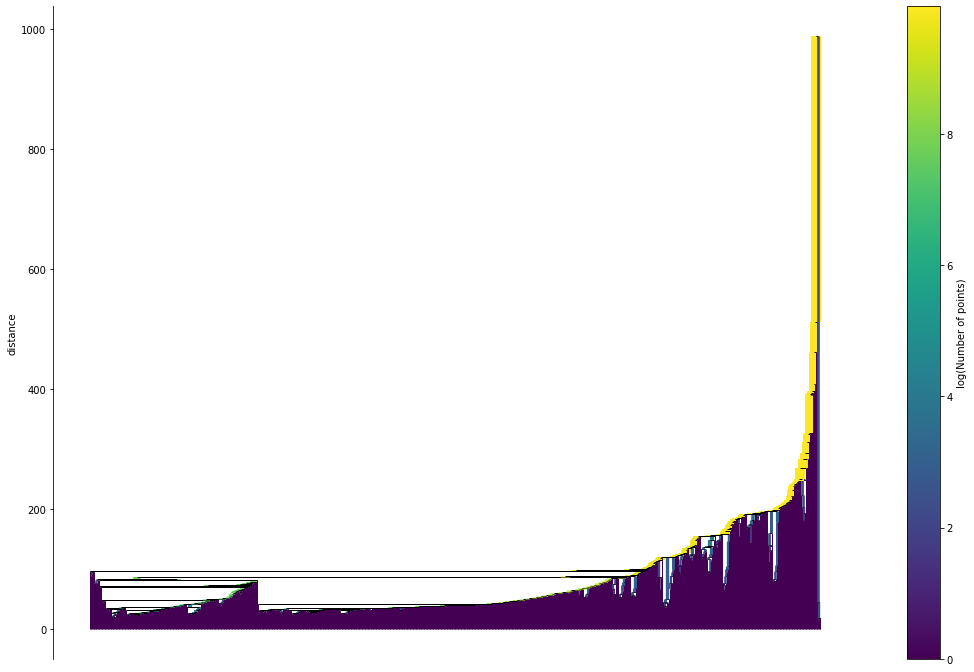

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
model.single_linkage_tree_.plot(cmap='viridis', colorbar=True, axis=ax)
plt.show()

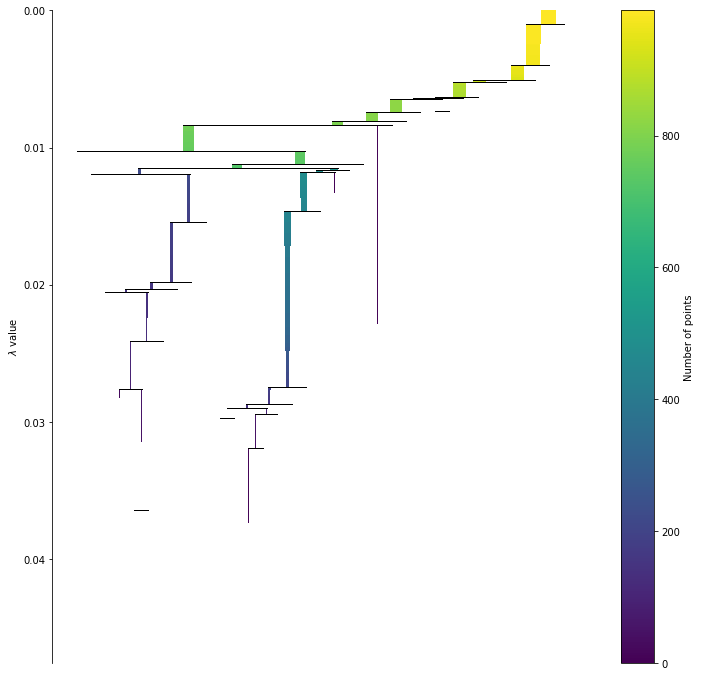

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
model.condensed_tree_.plot(axis=ax)
plt.show()

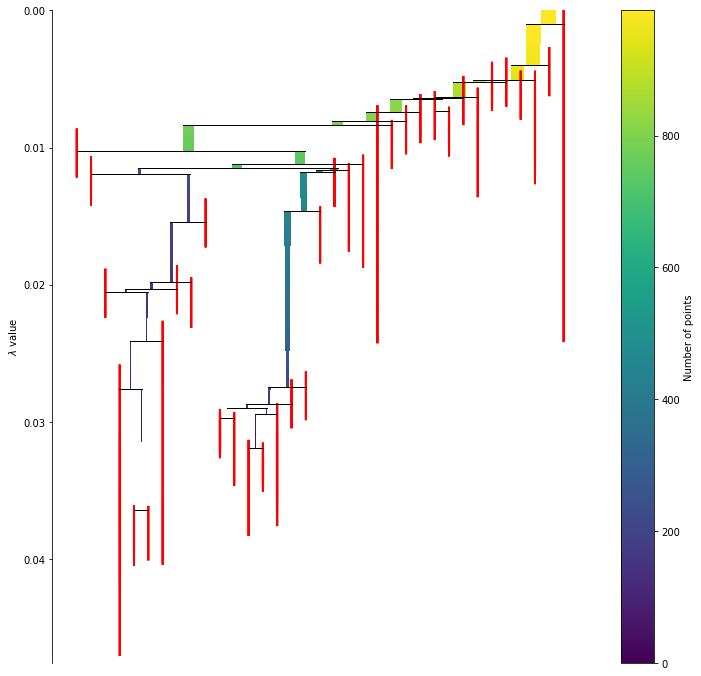

In [32]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(), axis=ax)
plt.show()

In [33]:
from sklearn.metrics import silhouette_score
silhouette_score(distance_matrix, model.labels_, metric='precomputed')

-0.3209423423962036